# DeBERTa for Named Entity Recognition (NER)
This notebook trains a DeBERTa-v3-base model for NER on movie review data.

**Entity Types:**
- ACTOR
- MOVIE
- CHARACTER
- DIRECTOR
- GENRE
- SERIES

# Install Dependencies

In [1]:
%pip install torch transformers datasets seqeval scikit-learn pandas numpy matplotlib seaborn protobuf sentencepiece accelerate -q


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, Features, Sequence, Value, ClassLabel
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
)
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [3]:
DATA_PATH = "train_ner.csv"
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LENGTH = 256
RANDOM_SEED = 42
OUTPUT_DIR = "deberta_ner_model"
SAVED_MODEL_DIR = "deberta_ner_saved"

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(RANDOM_SEED)

# Load Data

In [5]:
df = pd.read_csv(DATA_PATH)
print(f"Total samples: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Total samples: 1094

Columns: ['id', 'tokens', 'ner_tags']


,id,tokens,ner_tags
0,neg_0,Story of a man who has unnatural feelings for ...,O O O O O O O O O O O O O O O O O O O O O O O ...
1,neg_1,Robert DeNiro plays the most unbelievably inte...,B-ACTOR I-ACTOR O O O O O O O O O O O O O O O ...
2,neg_2,"I saw the capsule comment said ""great acting.""...",O O O O O O O O O O O O O O O O O O O O O O O ...
3,neg_3,If I had not read Pat Barker's 'Union Street' ...,O O O O O O O B-MOVIE I-MOVIE O O O O O O O O ...
4,neg_4,This fanciful horror flick has Vincent Price p...,O O B-GENRE O O B-ACTOR I-ACTOR O O O O O O O ...


# Exploratory Data Analysis (EDA)

## 1. Dataset Overview

In [6]:
# Calculate basic statistics
df['num_tokens'] = df['tokens'].apply(lambda x: len(x.split()))
df['num_entities'] = df['ner_tags'].apply(lambda x: sum(1 for tag in x.split() if tag.startswith('B-')))

print("=== Dataset Statistics ===")
print(f"Total reviews: {len(df)}")
print(f"\nToken statistics:")
print(f"  Mean tokens per review: {df['num_tokens'].mean():.2f}")
print(f"  Median tokens per review: {df['num_tokens'].median():.0f}")
print(f"  Min tokens: {df['num_tokens'].min()}")
print(f"  Max tokens: {df['num_tokens'].max()}")
print(f"\nEntity statistics:")
print(f"  Mean entities per review: {df['num_entities'].mean():.2f}")
print(f"  Median entities per review: {df['num_entities'].median():.0f}")
print(f"  Min entities: {df['num_entities'].min()}")
print(f"  Max entities: {df['num_entities'].max()}")

=== Dataset Statistics ===
Total reviews: 1094

Token statistics:
  Mean tokens per review: 232.10
  Median tokens per review: 170
  Min tokens: 11
  Max tokens: 1014

Entity statistics:
  Mean entities per review: 5.30
  Median entities per review: 4
  Min entities: 1
  Max entities: 43


## 2. Token Length Distribution

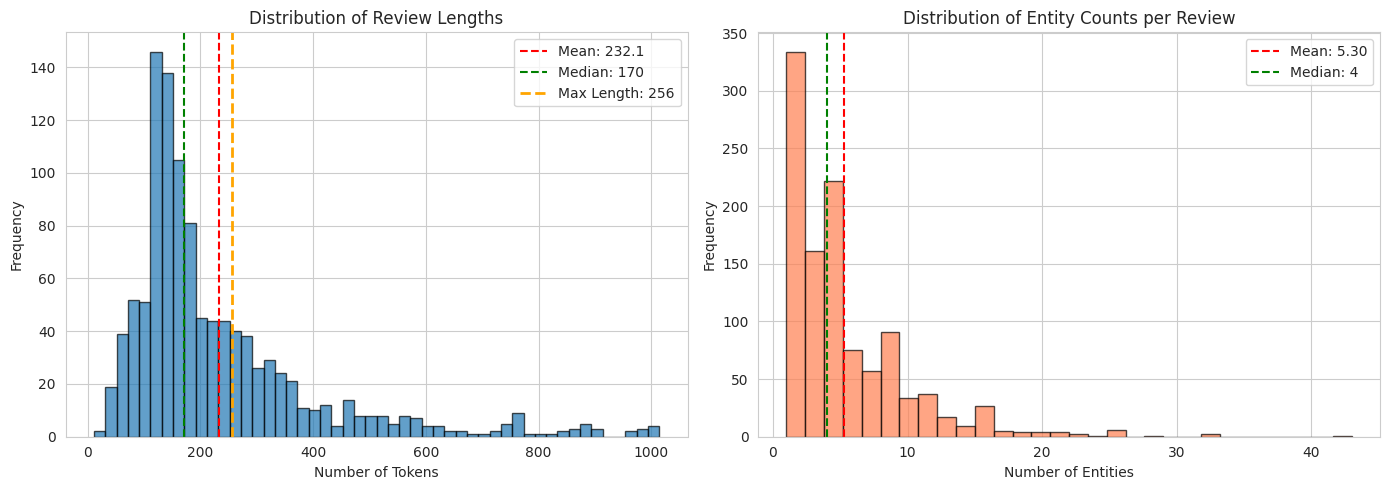


Reviews exceeding MAX_LENGTH (256): 321 (29.34%)


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Token length distribution
axes[0].hist(df['num_tokens'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(df['num_tokens'].mean(), color='red', linestyle='--', label=f'Mean: {df["num_tokens"].mean():.1f}')
axes[0].axvline(df['num_tokens'].median(), color='green', linestyle='--', label=f'Median: {df["num_tokens"].median():.0f}')
axes[0].axvline(MAX_LENGTH, color='orange', linestyle='--', linewidth=2, label=f'Max Length: {MAX_LENGTH}')
axes[0].set_xlabel('Number of Tokens')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Review Lengths')
axes[0].legend()

# Entity count distribution
axes[1].hist(df['num_entities'], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(df['num_entities'].mean(), color='red', linestyle='--', label=f'Mean: {df["num_entities"].mean():.2f}')
axes[1].axvline(df['num_entities'].median(), color='green', linestyle='--', label=f'Median: {df["num_entities"].median():.0f}')
axes[1].set_xlabel('Number of Entities')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Entity Counts per Review')
axes[1].legend()

plt.tight_layout()
plt.show()

# Check how many reviews exceed MAX_LENGTH
exceed_max = (df['num_tokens'] > MAX_LENGTH).sum()
print(f"\nReviews exceeding MAX_LENGTH ({MAX_LENGTH}): {exceed_max} ({exceed_max/len(df)*100:.2f}%)")

## 3. Entity Type Distribution

In [8]:
# Count all entity types across all reviews
entity_counts = Counter()
all_tags = []

for tags in df['ner_tags']:
    tag_list = tags.split()
    all_tags.extend(tag_list)
    # Count entities (B- tags only to avoid double counting)
    for tag in tag_list:
        if tag.startswith('B-'):
            entity_type = tag[2:]  # Remove 'B-' prefix
            entity_counts[entity_type] += 1

print("=== Entity Type Distribution ===")
total_entities = sum(entity_counts.values())
for entity_type, count in entity_counts.most_common():
    percentage = (count / total_entities) * 100
    print(f"{entity_type:12s}: {count:5d} ({percentage:5.2f}%)")

print(f"\nTotal entities: {total_entities}")

=== Entity Type Distribution ===
ACTOR       :  2178 (37.54%)
MOVIE       :  1629 (28.08%)
CHARACTER   :  1250 (21.54%)
DIRECTOR    :   479 ( 8.26%)
GENRE       :   266 ( 4.58%)

Total entities: 5802


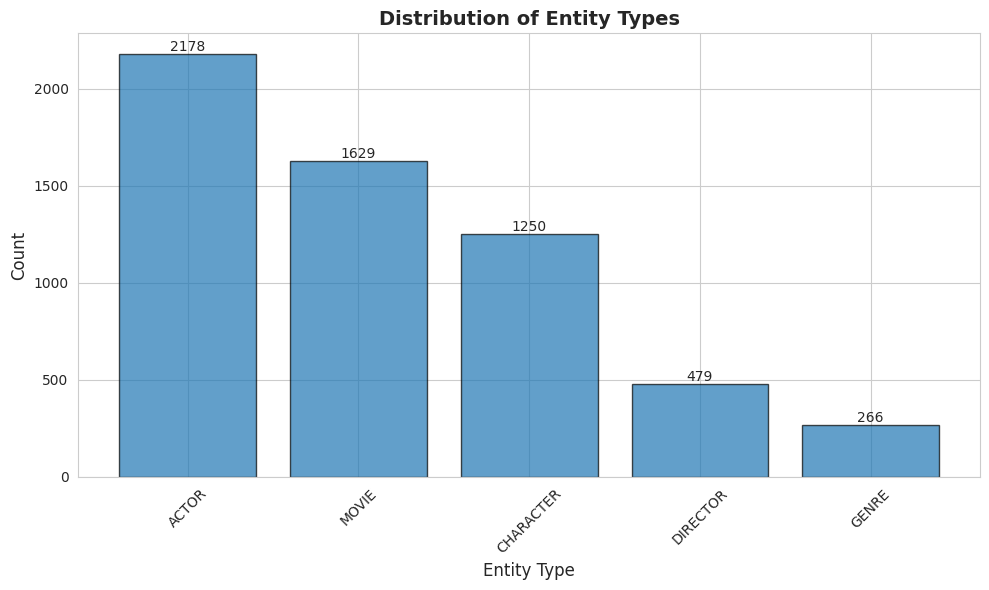

In [9]:
# Visualize entity distribution
entity_df = pd.DataFrame(entity_counts.most_common(), columns=['Entity Type', 'Count'])

plt.figure(figsize=(10, 6))
bars = plt.bar(entity_df['Entity Type'], entity_df['Count'], edgecolor='black', alpha=0.7)
plt.xlabel('Entity Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Entity Types', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 4. BIO Tag Distribution

In [10]:
# Count all BIO tags
tag_counts = Counter(all_tags)

print("=== BIO Tag Distribution ===")
print(f"Total tokens: {len(all_tags)}\n")

# Separate O tags from entity tags
o_count = tag_counts['O']
entity_tags = {k: v for k, v in tag_counts.items() if k != 'O'}

print(f"O (Outside): {o_count:7d} ({o_count/len(all_tags)*100:5.2f}%)")
print(f"Entity tags: {sum(entity_tags.values()):7d} ({sum(entity_tags.values())/len(all_tags)*100:5.2f}%)")
print("\nDetailed entity tag breakdown:")
for tag, count in sorted(entity_tags.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / len(all_tags)) * 100
    print(f"  {tag:15s}: {count:6d} ({percentage:5.2f}%)")

=== BIO Tag Distribution ===
Total tokens: 253915

O (Outside):  242686 (95.58%)
Entity tags:   11229 ( 4.42%)

Detailed entity tag breakdown:
  I-MOVIE        :   2396 ( 0.94%)
  B-ACTOR        :   2178 ( 0.86%)
  I-ACTOR        :   1961 ( 0.77%)
  B-MOVIE        :   1629 ( 0.64%)
  B-CHARACTER    :   1250 ( 0.49%)
  I-CHARACTER    :    627 ( 0.25%)
  B-DIRECTOR     :    479 ( 0.19%)
  I-DIRECTOR     :    390 ( 0.15%)
  B-GENRE        :    266 ( 0.10%)
  I-GENRE        :     53 ( 0.02%)


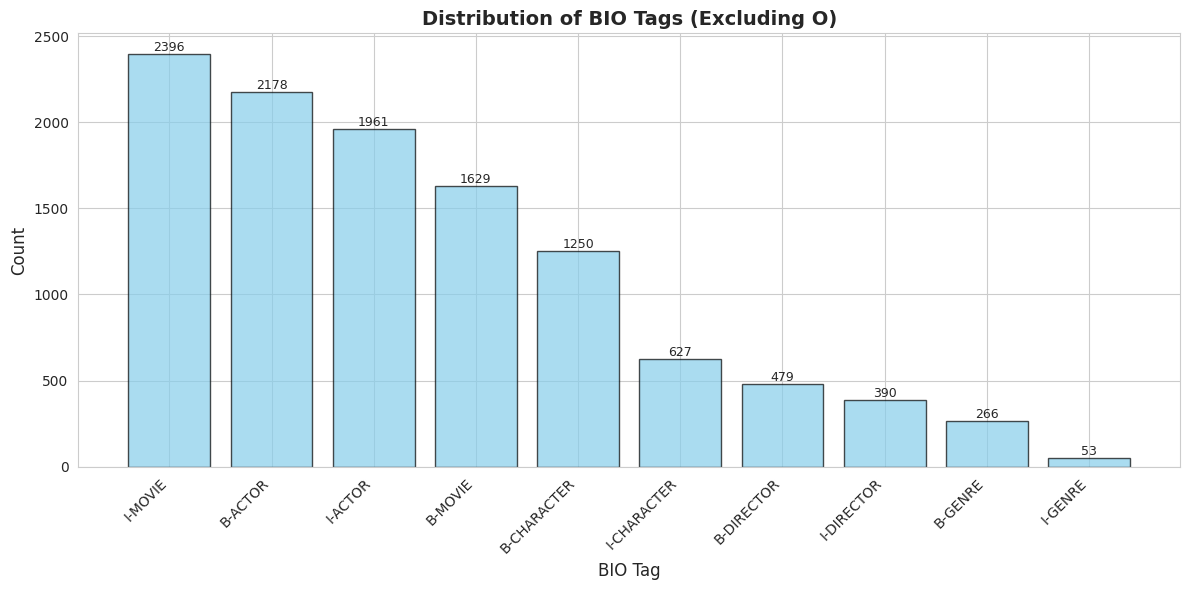

In [11]:
# Visualize BIO tag distribution (excluding O for better visibility)
entity_tag_df = pd.DataFrame(sorted(entity_tags.items(), key=lambda x: x[1], reverse=True),
                              columns=['Tag', 'Count'])

plt.figure(figsize=(12, 6))
bars = plt.bar(entity_tag_df['Tag'], entity_tag_df['Count'], edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('BIO Tag', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of BIO Tags (Excluding O)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 5. Class Imbalance Analysis

In [12]:
# Analyze class imbalance
total_tags = len(all_tags)
o_ratio = o_count / total_tags
entity_ratio = sum(entity_tags.values()) / total_tags

print("=== Class Imbalance Analysis ===")
print(f"O vs Entity ratio: {o_ratio:.4f} vs {entity_ratio:.4f}")
print(f"Imbalance ratio: {o_ratio/entity_ratio:.2f}:1 (O:Entity)")
print("\nThis shows the dataset is highly imbalanced (most tokens are 'O').")
print("We'll use seqeval metrics which focus on entity-level performance.")

=== Class Imbalance Analysis ===
O vs Entity ratio: 0.9558 vs 0.0442
Imbalance ratio: 21.61:1 (O:Entity)

This shows the dataset is highly imbalanced (most tokens are 'O').
We'll use seqeval metrics which focus on entity-level performance.


# Prepare Data for Training

In [13]:
# Extract unique labels
unique_labels = sorted(list(set(all_tags)))
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

print(f"Number of unique labels: {len(unique_labels)}")
print(f"\nLabels: {unique_labels}")

Number of unique labels: 11

Labels: ['B-ACTOR', 'B-CHARACTER', 'B-DIRECTOR', 'B-GENRE', 'B-MOVIE', 'I-ACTOR', 'I-CHARACTER', 'I-DIRECTOR', 'I-GENRE', 'I-MOVIE', 'O']


In [14]:
# Convert data to list format
def prepare_data(df):
    data = []
    for _, row in df.iterrows():
        tokens = row['tokens'].split()
        tags = row['ner_tags'].split()
        data.append({
            'id': row['id'],
            'tokens': tokens,
            'ner_tags': [label2id[tag] for tag in tags]
        })
    return data

data = prepare_data(df)
print(f"Prepared {len(data)} samples")
print(f"\nExample:")
print(f"Tokens: {data[0]['tokens'][:10]}")
print(f"Tags: {data[0]['ner_tags'][:10]}")

Prepared 1094 samples

Example:
Tokens: ['Story', 'of', 'a', 'man', 'who', 'has', 'unnatural', 'feelings', 'for', 'a']
Tags: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [15]:
# Split data
train_data, val_data = train_test_split(
    data,
    test_size=0.15,
    random_state=RANDOM_SEED
)

print(f"Train samples: {len(train_data)}")
print(f"Val samples: {len(val_data)}")

Train samples: 929
Val samples: 165


In [16]:
# Create HuggingFace datasets
train_ds = Dataset.from_list(train_data)
val_ds = Dataset.from_list(val_data)

dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 929
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 165
    })
})


# Tokenization

In [17]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [18]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=MAX_LENGTH,
        padding="max_length"
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                # Special tokens get -100 (ignored in loss)
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # First subword of a word gets the label
                label_ids.append(label[word_idx])
            else:
                # Subsequent subwords get -100 (ignored in loss)
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [19]:
encoded_ds = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset["train"].column_names
)

print(encoded_ds)

Map:   0%|          | 0/929 [00:00<?, ? examples/s]

Map: 100%|██████████| 165/165 [00:00<00:00, 1570.48 examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 929
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 165
    })
})


# Model Setup

In [20]:
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id,
)

print(f"Model loaded: {MODEL_NAME}")
print(f"Number of labels: {len(unique_labels)}")

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: microsoft/deberta-v3-base
Number of labels: 11


In [21]:
# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Training Configuration

In [22]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,

    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,

    fp16=True,
    report_to="none",
    seed=RANDOM_SEED,
)

In [23]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Convert to label names and filter out -100
    true_labels = []
    true_predictions = []

    for prediction, label in zip(predictions, labels):
        true_label = []
        true_prediction = []
        for pred, lab in zip(prediction, label):
            if lab != -100:  # Ignore special tokens
                true_label.append(id2label[lab])
                true_prediction.append(id2label[pred])
        true_labels.append(true_label)
        true_predictions.append(true_prediction)

    # Calculate metrics using seqeval
    precision = precision_score(true_labels, true_predictions)
    recall = recall_score(true_labels, true_predictions)
    f1 = f1_score(true_labels, true_predictions)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Train Model

In [24]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Starting training...")
trainer.train()

/tmp/ipykernel_7905/937411125.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Starting training...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,1.007700,0.082158,0.579580,0.564327,0.571852
2,0.072100,0.039786,0.765396,0.763158,0.764275
3,0.040200,0.034472,0.784530,0.830409,0.806818
4,0.026500,0.031897,0.796348,0.828947,0.812321
5,0.022000,0.031779,0.801408,0.831871,0.816356


TrainOutput(global_step=295, training_loss=0.2010113990913003, metrics={'train_runtime': 59.1643, 'train_samples_per_second': 78.51, 'train_steps_per_second': 4.986, 'total_flos': 606922055846400.0, 'train_loss': 0.2010113990913003, 'epoch': 5.0})

# Evaluation

In [25]:
print("===== Evaluation on validation set =====")
val_metrics = trainer.evaluate(encoded_ds["validation"])
for k, v in val_metrics.items():
    print(f"{k}: {v:.4f}")

===== Evaluation on validation set =====


eval_loss: 0.0318
eval_precision: 0.8014
eval_recall: 0.8319
eval_f1: 0.8164
eval_runtime: 0.6918
eval_samples_per_second: 238.5050
eval_steps_per_second: 8.6730
epoch: 5.0000


In [26]:
# Get detailed classification report
predictions, labels, _ = trainer.predict(encoded_ds["validation"])
predictions = np.argmax(predictions, axis=2)

# Convert to label names
true_labels = []
true_predictions = []

for prediction, label in zip(predictions, labels):
    true_label = []
    true_prediction = []
    for pred, lab in zip(prediction, label):
        if lab != -100:
            true_label.append(id2label[lab])
            true_prediction.append(id2label[pred])
    true_labels.append(true_label)
    true_predictions.append(true_prediction)

print("\n===== Detailed Classification Report =====")
print(classification_report(true_labels, true_predictions))


===== Detailed Classification Report =====
              precision    recall  f1-score   support

       ACTOR       0.90      0.89      0.89       259
   CHARACTER       0.76      0.84      0.80       149
    DIRECTOR       0.74      0.84      0.79        55
       GENRE       0.29      0.26      0.27        35
       MOVIE       0.81      0.85      0.83       186

   micro avg       0.80      0.83      0.82       684
   macro avg       0.70      0.74      0.72       684
weighted avg       0.80      0.83      0.82       684

              precision    recall  f1-score   support

       ACTOR       0.90      0.89      0.89       259
   CHARACTER       0.76      0.84      0.80       149
    DIRECTOR       0.74      0.84      0.79        55
       GENRE       0.29      0.26      0.27        35
       MOVIE       0.81      0.85      0.83       186

   micro avg       0.80      0.83      0.82       684
   macro avg       0.70      0.74      0.72       684
weighted avg       0.80      0.83

# Save Model

In [27]:
trainer.model.save_pretrained(SAVED_MODEL_DIR)
tokenizer.save_pretrained(SAVED_MODEL_DIR)
print(f"Model saved to: {SAVED_MODEL_DIR}")

Model saved to: deberta_ner_saved


# Test Predictions

In [28]:
# Load the saved model for inference
from transformers import pipeline

ner_pipeline = pipeline(
    "token-classification",
    model=SAVED_MODEL_DIR,
    tokenizer=SAVED_MODEL_DIR,
    aggregation_strategy="simple"
)

# Test examples
test_texts = [
    "Christopher Nolan directed Inception starring Leonardo DiCaprio.",
    "The Dark Knight is one of the best action movies ever made.",
    "Tom Hanks played the role of Forrest Gump brilliantly.",
]

print("===== Test Predictions =====")
for text in test_texts:
    print(f"\nText: {text}")
    results = ner_pipeline(text)
    print("Entities:")
    for result in results:
        print(f"  {result['word']:20s} -> {result['entity_group']:12s} (score: {result['score']:.3f})")

Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


===== Test Predictions =====

Text: Christopher Nolan directed Inception starring Leonardo DiCaprio.
Entities:
  Christopher Nolan    -> DIRECTOR     (score: 0.887)
  Inception            -> MOVIE        (score: 0.901)
  Leonardo DiCaprio    -> ACTOR        (score: 0.951)

Text: The Dark Knight is one of the best action movies ever made.
Entities:
  The Dark Knight      -> MOVIE        (score: 0.977)

Text: Tom Hanks played the role of Forrest Gump brilliantly.
Entities:
  Tom Hanks            -> ACTOR        (score: 0.979)
  Forrest Gump         -> CHARACTER    (score: 0.790)
Entities:
  Tom Hanks            -> ACTOR        (score: 0.979)
  Forrest Gump         -> CHARACTER    (score: 0.790)
